<a href="https://colab.research.google.com/github/Asfilcnx3/Project8_hymenop/blob/main/hymenoptera_proyecto8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vamos a hacer "Transfer Learning" para "Computer Vision" con Resnet50 y vamos a clasificar abejas y hormigas

In [1]:
# Importamos todas las librerias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn # la aceleración GPU
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image # trabajaremos con imagenes así que usamos esta librería
from os import path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR
import seaborn as sns

cudnn.benchmark = True # con esto encontramos los mejores algoritmos para el uso de "Cuda"
plt.ion()   # Activamos el modo interactivo de matplotlib

### Vamos a necesitar descargar el dataset:
* `https://download.pytorch.org/tutorial/hymenoptera_data.zip`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Usaremos Data Aumentation y Normalization para las fotos
# Contamos con 120 imagenes para entrenamiento y 75 para validación

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r"/content/drive/MyDrive/hymenoptera_data"

# Tenemos que iterar sobre cada uno de los archivos en las carpetas y aplicarles la transformación
image_dataset = {x: datasets.ImageFolder(path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=2) for x in ["train", "val"]}

# Guardamos las clases y el largo de los datasets (entrenamiento y validación)
dataset_sizes = {x: len(image_dataset[x]) for x in ["train", "val"]}
class_names = image_dataset["train"].classes

# Usaremos el acelerador de cuda
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Estamos usando: {device}")

Estamos usando: cuda


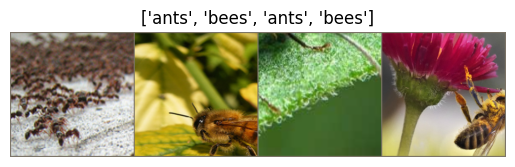

In [4]:
# Vamos a visualizar las imagenes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # convertimos la imagen (tensor) a un array de numpy y transponemos sus dimensiones
    mean = np.array([0.485, 0.456, 0.406]) # son los datos usados en la normalización de los datos
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Hacemos el reverso de la normalización de arriba
    inp = np.clip(inp, 0, 1) # hacemos que los pixeles tengan un rango entre 0 y 1
    plt.imshow(inp) # mostramos
    plt.axis("off") # quitamos ejes
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pausamos cada ejecución para evitar errores


# Necesitamos una parte de los datos
input, classes = next(iter(dataloaders["train"])) # tomamos una parte de los datos (input -> imagen, classes -> etiqueta)
out = torchvision.utils.make_grid(input) # Hacemos que las imagenes tengan la forma correcta para visualizarlo
imshow(out, title=[class_names[x] for x in classes]) # ejecutamos la función anterior

In [32]:
def train_model(model, loss_fn, optimizer, scheduler, patience, num_epochs=25):
  best_acc = 0.0
  counter = 0
  best_val_loss = float('inf')

  # Definimos las 3 variables con las que vamos a visualizar los datos
  train_losses = []
  val_losses = []
  val_accs = []

  for epoch in range(num_epochs):
    print("------"*10)

    # Cada época tendrá su fase de validación y de entrenamiento
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      all_preds = []
      all_labels = []

      # Iteramos sobre los datos
      for images, labels in dataloaders[phase]:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Si estamos en fase de entrenamiento
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(images)
          loss = loss_fn(outputs, labels)

          # Optimizamos solo si estamos en fase de entrenamiento
          if phase == "train":
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)


        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      epoch_loss = running_loss / len(image_dataset[phase])
      epoch_acc = accuracy_score(all_labels, all_preds)

      if phase == "train":
        train_losses.append(running_loss / len(image_dataset["train"]))
        scheduler.step()
      else:
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        if val_losses[-1] < best_val_loss:
          best_val_loss = val_losses[-1]
          counter = 0
          torch.save(model.state_dict(), "cifar10_best_model.pt")

        else:
          counter += 1
          if counter >= patience:
            print(f"Early stopping guardado en la época: {(epoch + 1) - patience}")
            model.load_state_dict(torch.load("cifar10_best_model.pt"))
            return model, train_losses, val_losses, val_accs, all_preds, all_labels

      if phase == "val":
        print(f"Epoch: {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.3f}")
        if val_losses and val_accs:
          print(f"Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accs[-1] * 100:.2f}%")
        else:
          print("Sin métricas de validación disponibles.")

  model.load_state_dict(torch.load("cifar10_best_model.pt"))
  return model, train_losses, val_losses, val_accs, all_preds, all_labels

In [6]:
def visualize_graphics_vs_graphics(train1, val1, accs1, train2, val2, accs2):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train1, label="Train Loss", color= "teal")
  plt.plot(val1, label="Val Loss", color="c")
  plt.plot(accs1, label="Val Accuracy", color = "aqua")
  plt.title("Entrenamiento vs Validación vs Precisión")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(train2, label="Train Loss", color="plum")
  plt.plot(val2, label="Val Loss", color="darkmagenta")
  plt.plot(accs2, label="Val Accuracy", color="orchid")
  plt.title("Entrenamiento vs Validación vs Precisión")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

## Ahora vamos a probar ConvNet en finetuning y en fixed feature extractor, junto con la visualización de sus propias gráficas

In [39]:
# Empezamos con finetuning
model_ft = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

lr_scheduler = StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [40]:
# Entrenamos
model_ft, train_losses_ft, val_losses_ft, val_accs_ft, all_preds_ft, all_labels_ft = train_model(model_ft, loss_fn, optimizer_ft, lr_scheduler, patience=7, num_epochs=30)

------------------------------------------------------------
Epoch: 1/30
Train Loss: 0.625
Val Loss: 0.426, Val Acc: 94.77%
------------------------------------------------------------
Epoch: 2/30
Train Loss: 0.427
Val Loss: 0.228, Val Acc: 96.73%
------------------------------------------------------------
Epoch: 3/30
Train Loss: 0.343
Val Loss: 0.183, Val Acc: 97.39%
------------------------------------------------------------
Epoch: 4/30
Train Loss: 0.316
Val Loss: 0.144, Val Acc: 98.04%
------------------------------------------------------------
Epoch: 5/30
Train Loss: 0.256
Val Loss: 0.148, Val Acc: 97.39%
------------------------------------------------------------
Epoch: 6/30
Train Loss: 0.210
Val Loss: 0.131, Val Acc: 97.39%
------------------------------------------------------------
Epoch: 7/30
Train Loss: 0.246
Val Loss: 0.136, Val Acc: 96.08%
------------------------------------------------------------
Epoch: 8/30
Train Loss: 0.190
Val Loss: 0.118, Val Acc: 97.39%
--------

In [41]:
#Ahora el model fixed feature extractor

model_conv = torchvision.models.resnet50(weights="IMAGENET1K_V2")
for param in model_conv.parameters():
  param.requires_grad = False  # Para que no se mejore

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv.to(device)

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

lr_scheduler_conv = StepLR(optimizer_conv, step_size=7, gamma=0.1)
# Usaremos la misma función de perdida

In [42]:
# Entrenamos
model_conv, train_losses_conv, val_losses_conv, val_accs_conv, all_preds_conv, all_labels_conv = train_model(
    model_conv,
    loss_fn,
    optimizer_conv,
    lr_scheduler_conv,
    patience=7,
    num_epochs=30
)

------------------------------------------------------------
Epoch: 1/30
Train Loss: 0.627
Val Loss: 0.429, Val Acc: 94.12%
------------------------------------------------------------
Epoch: 2/30
Train Loss: 0.479
Val Loss: 0.324, Val Acc: 97.39%
------------------------------------------------------------
Epoch: 3/30
Train Loss: 0.432
Val Loss: 0.283, Val Acc: 96.73%
------------------------------------------------------------
Epoch: 4/30
Train Loss: 0.378
Val Loss: 0.237, Val Acc: 96.73%
------------------------------------------------------------
Epoch: 5/30
Train Loss: 0.360
Val Loss: 0.220, Val Acc: 94.77%
------------------------------------------------------------
Epoch: 6/30
Train Loss: 0.352
Val Loss: 0.181, Val Acc: 98.04%
------------------------------------------------------------
Epoch: 7/30
Train Loss: 0.339
Val Loss: 0.183, Val Acc: 96.08%
------------------------------------------------------------
Epoch: 8/30
Train Loss: 0.286
Val Loss: 0.186, Val Acc: 96.73%
--------

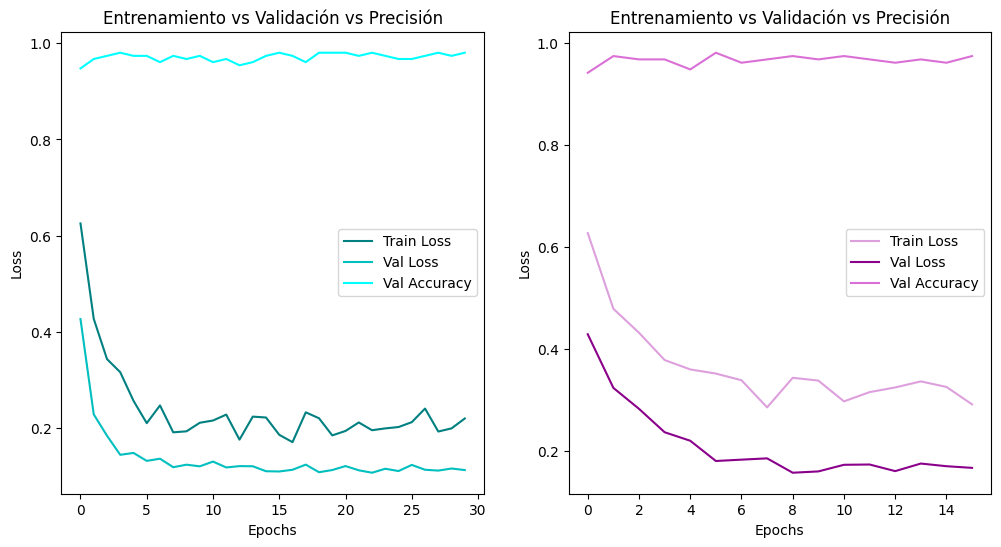

In [43]:
visualize_graphics_vs_graphics(
    train_losses_ft,
    val_losses_ft,
    val_accs_ft,
    train_losses_conv,
    val_losses_conv,
    val_accs_conv
)

In [44]:
# Podemos hacer un clasification report y una confusion matrix
print("Classification report modelo FT:")
print(classification_report(all_labels_ft, all_preds_ft, target_names = class_names))
print("Classification report modelo CONV:")
print(classification_report(all_labels_conv, all_preds_conv, target_names = class_names))

Classification report modelo FT:
              precision    recall  f1-score   support

        ants       0.99      0.97      0.98        70
        bees       0.98      0.99      0.98        83

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153

Classification report modelo CONV:
              precision    recall  f1-score   support

        ants       0.99      0.96      0.97        70
        bees       0.96      0.99      0.98        83

    accuracy                           0.97       153
   macro avg       0.98      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



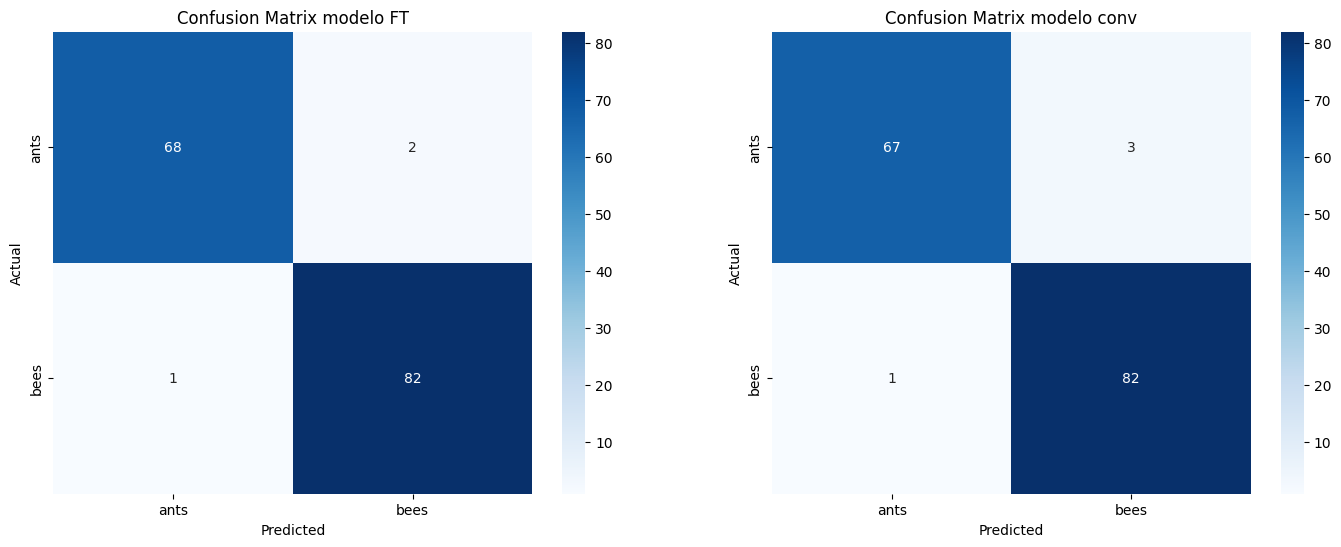

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17,6))

sns.heatmap(confusion_matrix(all_labels_ft, all_preds_ft), annot=True, cmap="Blues",fmt='d' , xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")
axs[0].set_title("Confusion Matrix modelo FT")

sns.heatmap(confusion_matrix(all_labels_conv, all_preds_conv), annot=True, cmap="Blues" ,fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")
axs[1].set_title("Confusion Matrix modelo conv")

plt.show()